# Dataset Initialization

In [1]:
from point2vec.datasets import LArNetDataModule
import matplotlib.pyplot as plt
import torch
import numpy as np

# Turn off gradient tracking so we don't run out of memory
torch.set_grad_enabled(False)

In [22]:
dataset = LArNetDataModule(
    data_path=f'/sdf/home/y/youngsam/data/dune/larnet/h5/DataAccessExamples/train/generic_v2*.h5',
    batch_size=24,
    num_workers=0,
    dataset_kwargs={
        'emin': 1.0e-6,                      # min energy for log transform
        'emax': 20.0,                        # max energy for log transform
        'energy_threshold': 0.13,            # remove points with energy < 0.13
        'remove_low_energy_scatters': True,  # remove low energy scatters (PID=4)
        'maxlen': -1,                        # max number of events to load
        'normalize': True,                   # normalize point cloud to unit sphere
    }
)
dataset.setup()

[DATASET] self.emin=1e-06, self.emax=20.0, self.energy_threshold=0.13, self.normalize=True, self.remove_low_energy_scatters=True
[DATASET] Building index
[DATASET] 864064 point clouds were loaded
[DATASET] 10 files were loaded
[DATASET] self.emin=1e-06, self.emax=20.0, self.energy_threshold=0.13, self.normalize=True, self.remove_low_energy_scatters=True
[DATASET] Building index
[DATASET] 8531 point clouds were loaded
[DATASET] 1 files were loaded


# Use a pre-trained model

In [4]:
from point2vec.models import PointMAE
from glob import glob
import os

def get_newest_ckpt(ckpt_path):
    ckpt_path = glob(f'{ckpt_path}/**/*.ckpt')
    newest_ckpt = max(ckpt_path, key=os.path.getctime)
    return newest_ckpt

wandb_run_id = 'fjnp0snd'
ckpt_path = f'/sdf/home/y/youngsam/sw/dune/representations/point2vec/PointMAE-Pretraining-LArNet-5voxel/{wandb_run_id}'

model = PointMAE.load_from_checkpoint(
    get_newest_ckpt(ckpt_path)
).cuda()
model.eval();

/sdf/home/y/youngsam/sw/dune/.conda/envs/py310/lib/python3.10/site-packages/lightning_fabric/utilities/cloud_io.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

In [17]:
# Inference on one batch
for batch in dataset.train_dataloader():
    points, lengths, semantic_id, endpoints = batch
    points = points.cuda()
    lengths = lengths.cuda()

    embeddings, centers, mask, semantic_ids, endpoint_groups, groups, point_mask = model.tokenizer(
        points, lengths, None, None, return_point_info=True)
    masked, unmasked = model.masking(centers, mask.sum(-1))
    
    w_m = masked.unsqueeze(-1)
    w_u = unmasked.unsqueeze(-1)

    pos = model.center_encoding(centers)

    B, _, C = embeddings.shape

    visible_embeddings = embeddings * w_u

    encoder_output_embeddings = model.encoder(
        visible_embeddings, pos, w_u.bool().squeeze()
    ).last_hidden_state # (B, T, C)

    decoder_mask = w_m.bool().squeeze() | w_u.bool().squeeze()
    total_embeddings = (encoder_output_embeddings * w_u) + (w_m * model.mask_token)
    decoder_output_embeddings = model.decoder(
        total_embeddings, pos, decoder_mask
    ).last_hidden_state

    masked_output_embeddings = decoder_output_embeddings[masked]

    upscaled = model.increase_dim(masked_output_embeddings.transpose(0, 1)).transpose(0, 1)
    upscaled = upscaled.reshape(upscaled.shape[0], -1, model.hparams.num_channels)
    break

`upscaled` is flattened so we need to reconstruct it to be the original shape of `groups`.

In [18]:
upscaled_pts = torch.zeros_like(groups)
upscaled_pts[masked] = upscaled

rescaled_groups = groups.clone()
rescaled_groups[:, :, :, :3] *= model.hparams.tokenizer_group_radius
rescaled_groups[:, :, :, :3] = rescaled_groups[:, :, :, :3] + centers[:, :, None, :3]

rescaled_upscaled_pts = upscaled_pts.clone()
rescaled_upscaled_pts[:, :, :, :3] *= model.hparams.tokenizer_group_radius
rescaled_upscaled_pts[:, :, :, :3] = rescaled_upscaled_pts[:, :, :, :3] + centers[:, :, None, :3]

# Get point lengths for each event
point_lengths = torch.zeros_like(mask).long()
point_lengths[unmasked] = point_mask[unmasked].sum(-1)
point_lengths[masked] = point_mask[masked].sum(-1)

In [19]:
event_idx = 1

# Get original (unmasked) and upscaled (masked) points
orig_pts = rescaled_groups[event_idx][unmasked[event_idx]].cpu().numpy()
upscaled_pts = rescaled_upscaled_pts[event_idx][masked[event_idx]].cpu().numpy()

# Get point lengths for just our event
unmasked_lengths = point_lengths[event_idx][unmasked[event_idx]].cpu().numpy()
masked_lengths = point_lengths[event_idx][masked[event_idx]].cpu().numpy()
point_lengths = point_lengths.cpu().numpy()
groups = groups.cpu().numpy()

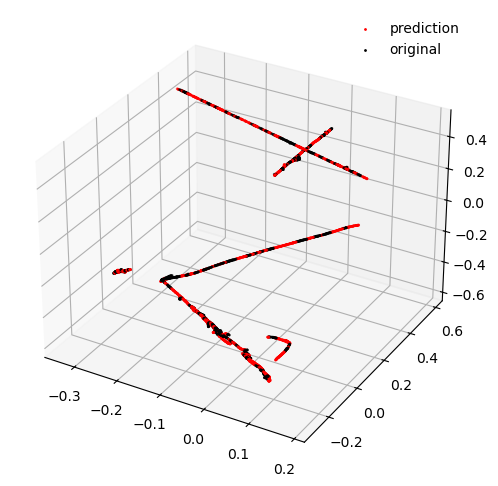

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import numpy as np

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

for i in range(masked_lengths.shape[0]):
    ax.scatter(
        upscaled_pts[i, :masked_lengths[i]][:, 0],
        upscaled_pts[i, :masked_lengths[i]][:, 1],
        upscaled_pts[i, :masked_lengths[i]][:, 2],
        c='red',
        s=1,
        label='prediction' if i == 0 else None
    )

for i in range(unmasked_lengths.shape[0]):
    ax.scatter(
        orig_pts[i, :unmasked_lengths[i]][:, 0],
        orig_pts[i, :unmasked_lengths[i]][:, 1],
        orig_pts[i, :unmasked_lengths[i]][:, 2],
        c='black',
        s=1,
        label='original' if i == 0 else None
    )

ax.legend(frameon=False, loc='upper right')
plt.show()

# Embedding tSNE

What also may be interesting is to see the tSNE of the embeddings.

In [10]:
all_embeddings = []
all_semantic_ids = []

for i, batch in enumerate(dataset.train_dataloader()):
    points, lengths, semantic_id, endpoints = batch
    points = points.cuda()
    lengths = lengths.cuda()
    semantic_id = semantic_id.cuda()
    tokens, centers, mask, semantic_ids, endpoint_groups, groups, point_mask = model.tokenizer(
        points, lengths, semantic_id, None, return_point_info=True)
    pos = model.center_encoding(centers)

    encoder_output_embeddings = model.encoder(
        tokens, pos, mask
    ).last_hidden_state # (B, T, C)

    all_embeddings.append(encoder_output_embeddings[mask].cpu().numpy())
    all_semantic_ids.append(semantic_ids[mask].cpu().numpy())
    if i > 10:
        break

all_embeddings = np.concatenate(all_embeddings, axis=0)
all_semantic_ids = np.concatenate(all_semantic_ids, axis=0)

In [11]:
print(f'Running tSNE on {all_embeddings.shape[0]} embeddings')

import numpy as np
import matplotlib.pyplot as plt

semantic_ids = all_semantic_ids.squeeze()
x = all_embeddings.reshape(-1, 384)

def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (0, 2, 4))

palette = [
    '#79B5A4',
    '#F5D69B',
    '#185890',
    '#BA4A09',
]

palette = np.array([hex_to_rgb(color) for color in palette])


unique_semantic_ids = np.unique(semantic_ids)
unique_semantic_ids = unique_semantic_ids[unique_semantic_ids != -1]
semantic_id_to_color = {
    semantic_id: palette[i]
    for i, semantic_id in enumerate(unique_semantic_ids)
}  # RGB colors

group_colors = np.zeros((x.shape[0], 3))
group_labels = np.zeros((x.shape[0], 1))
for i in range(x.shape[0]):  # For each group
    group_semantic_ids = semantic_ids[i, :]  # Semantic IDs in the group
    group_semantic_ids = group_semantic_ids[group_semantic_ids != -1]
    unique_ids, counts = np.unique(group_semantic_ids, return_counts=True)
    total_counts = counts.sum()
    weights = counts / total_counts  # Proportions of each semantic ID

    # Get the colors for the unique semantic IDs in the group
    colors = np.array([semantic_id_to_color[uid] for uid in unique_ids])

    # Compute the weighted average color
    weighted_colors = colors * weights[:, np.newaxis]
    group_color = weighted_colors.sum(axis=0)
    group_colors[i] = group_color
    group_labels[i] = unique_ids[counts.argmax()]

Running tSNE on 101753 embeddings


In [12]:
from tsnecuda import TSNE

x_train = TSNE().fit_transform(x)

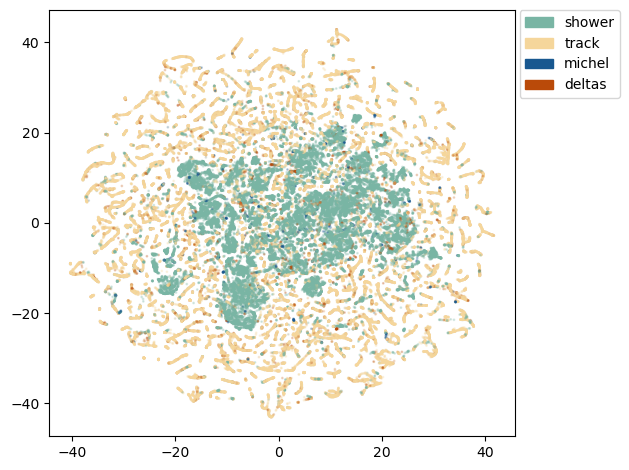

In [13]:
import matplotlib.patches as mpatches

legend_handles = []
id_to_pid = {0: "shower", 1: "track", 2: "michel", 3: "deltas", 4: "low energy dep"}

plt.scatter(
    x_train[:, 0],
    x_train[:, 1],
    c=group_colors[:],
    s=1,
    alpha=0.25,
)

for i, semantic_id in enumerate(unique_semantic_ids):
    patch = mpatches.Patch(color=palette[i], label=id_to_pid[int(semantic_id)])
    legend_handles.append(patch)

plt.legend(
    handles=legend_handles,
    bbox_to_anchor=(1.01, 1),
    loc="upper left",
    borderaxespad=0.0,
)
plt.tight_layout()
plt.show()


# Embedding PCA

We may also be interested in seeing the variation of the embeddings in a single event.

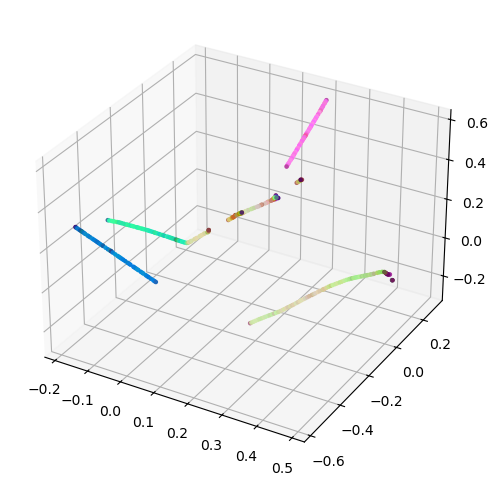

In [15]:
from sklearn.decomposition import PCA

event_idx = 1
example_embeddings = tokens[event_idx][mask[event_idx]].cpu().numpy()
example_centers = centers[event_idx][mask[event_idx]].cpu().numpy()

pca = PCA(n_components=3).fit(example_embeddings)
scaled_embeddings = pca.transform(example_embeddings)
scaled_embeddings = (scaled_embeddings - scaled_embeddings.min(axis=0)) / (scaled_embeddings.max(axis=0) - scaled_embeddings.min(axis=0))

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    example_centers[:, 0],
    example_centers[:, 1],
    example_centers[:, 2],
    color=scaled_embeddings[:],
    s=5,
    alpha=1.0,
)
plt.show()